## Generate a dataset

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
%matplotlib inline

np.random.seed(42)

# Generate train data
X = 0.3 * np.random.randn(100, 2)
# Generate some abnormal novel observations
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))
X = np.r_[X + 2, X - 2, X_outliers]


#### 1. Generate train data
`X = 0.3 * np.random.randn(100, 2)`
- This line generates 100 samples from a normal distribution (mean = 0, standard deviation = 0.3) for two features (hence the shape (100, 2)).
- The generated points are clustered around the origin, creating a dense area of normal observations.
#### 2. Generate Outlier Observations
`X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))`
This line creates 20 outlier observations sampled uniformly from a range of -4 to 4 for both features. These points will be scattered over a wider area compared to the normal data points.
#### 3. Generate some abnormal novel observations
`X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))`

This line combines the normal observations with the outliers:

- `X + 2`: Translates one cluster of normal observations to the right.
- `X - 2`: Translates another cluster of normal observations to the left.
- `X_outliers`: Adds the generated outlier observations to the dataset.

The result is a dataset X that contains two clusters of normal points and some scattered outliers.

In [6]:
plt.rcParams["figure.figsize"] = (10,10)

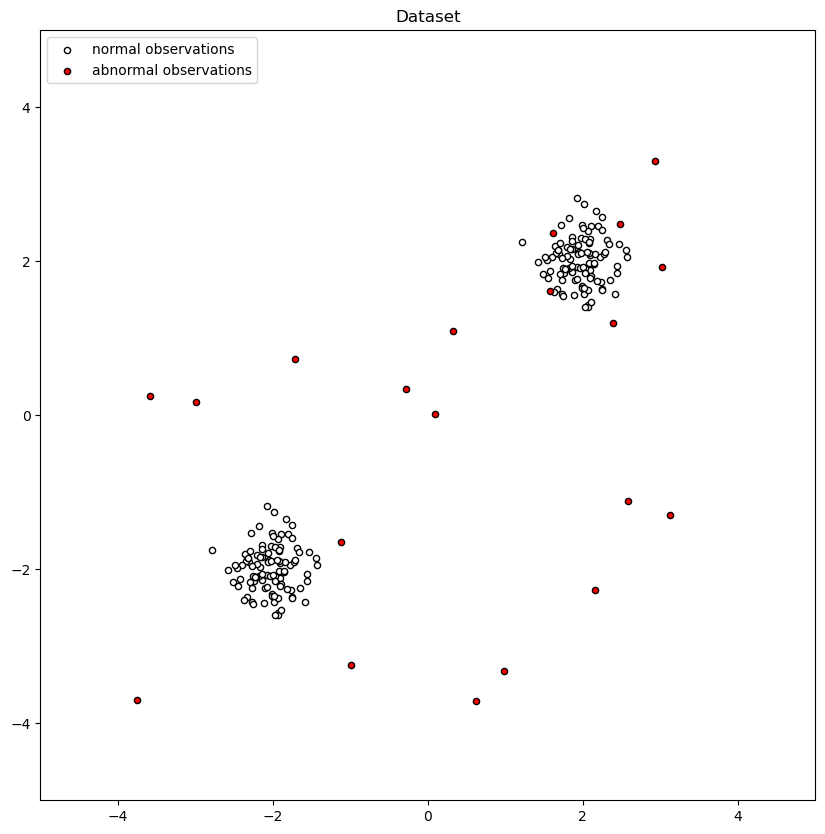

In [7]:
a = plt.scatter(X[:200, 0], X[:200, 1], c='white',
                edgecolor='k', s=20)
b = plt.scatter(X[200:, 0], X[200:, 1], c='red',
                edgecolor='k', s=20)

plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a, b],
           ["normal observations",
            "abnormal observations"],
           loc="upper left")

plt.title("Dataset")

plt.show()


In [8]:
import pandas as pd

pd.DataFrame(X).to_csv("outliers.csv", index=False)

## Automatic multivariate tools

### Local Outlier Factor (LOF)

Overview: Local Outlier Factor is an anomaly detection algorithm that identifies outliers by measuring the local density of data points. The key idea is that outliers are points that have a significantly lower density than their neighbors.
How LOF Works:

Density-Based Approach: LOF calculates the density of data points based on their distances to neighboring points. It uses the concept of reachability distance to evaluate the density of a point relative to its neighbors.

Key Steps:
- Neighborhood Calculation: For each point, identify its k nearest neighbors based on a distance metric (usually Euclidean distance).
- Local Reachability Density (LRD): Compute the LRD for each point, which is defined as the inverse of the average reachability distance of the point from its neighbors. It reflects how dense the point is compared to its neighbors.
- LOF Score Calculation: For each point, the LOF score is calculated by comparing its LRD to the LRDs of its neighbors. A score greater than 1 indicates that the point is an outlier, with higher scores indicating a stronger outlier status.

Interpretation of LOF Scores:
- LOF Score < 1: The point is in a denser region than its neighbors (normal).
- LOF Score ≈ 1: The point has a similar density to its neighbors (normal).
- LOF Score > 1: The point is in a less dense region than its neighbors (outlier).

Advantages:
- Effective for detecting local outliers in datasets with varying densities.
- Does not assume a global distribution for the data.

Applications:
- Fraud detection, network security, and anomaly detection in various fields such as finance, healthcare, and manufacturing.

### Isolation Forest
Overview: Isolation Forest is an ensemble-based anomaly detection technique specifically designed for high-dimensional datasets. It operates by isolating observations in the data.
How Isolation Forest Works:

Isolation Principle: The fundamental idea behind Isolation Forest is that anomalies are "few and different." Therefore, they can be isolated from the rest of the data more easily compared to normal points.

Key Steps:
- Random Partitioning: Create a number of isolation trees by randomly selecting a feature and then randomly selecting a split value within the range of that feature. This process is repeated recursively to partition the data.
- Tree Construction: Each tree is constructed until all points are isolated or until a pre-defined depth is reached. This process creates a binary tree structure where each leaf node represents a subset of the data.
- Path Length Measurement: For each data point, calculate the average path length across all trees. Anomalies will have shorter path lengths because they are easier to isolate.
- Anomaly Score Calculation: The anomaly score is derived from the average path length. Shorter path lengths correspond to higher anomaly scores.

Advantages:
- Works well with high-dimensional data.
- Efficient and scalable, especially suitable for large datasets.
- Does not require assumptions about the distribution of the data.

### Summary of Differences
- Approach: LOF is density-based, focusing on the local density of data points, while Isolation Forest is based on the idea of isolating data points through random partitioning.
- Sensitivity to Density Variations: LOF excels in identifying local outliers in data with varying densities, while Isolation Forest is effective in high-dimensional datasets with a global view of outlier detection.
- Performance: Isolation Forest is generally faster and more scalable for large datasets compared to LOF, which may struggle with very large datasets due to its density calculations.

In [9]:
from sklearn.neighbors import LocalOutlierFactor

n_outliers = len(X_outliers)
ground_truth = np.ones(len(X), dtype=int)
ground_truth[-n_outliers:] = -1

# fit the model
clf = LocalOutlierFactor(n_neighbors=20, novelty=True)
clf.fit(X)
y_pred = clf.predict(X)
n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_

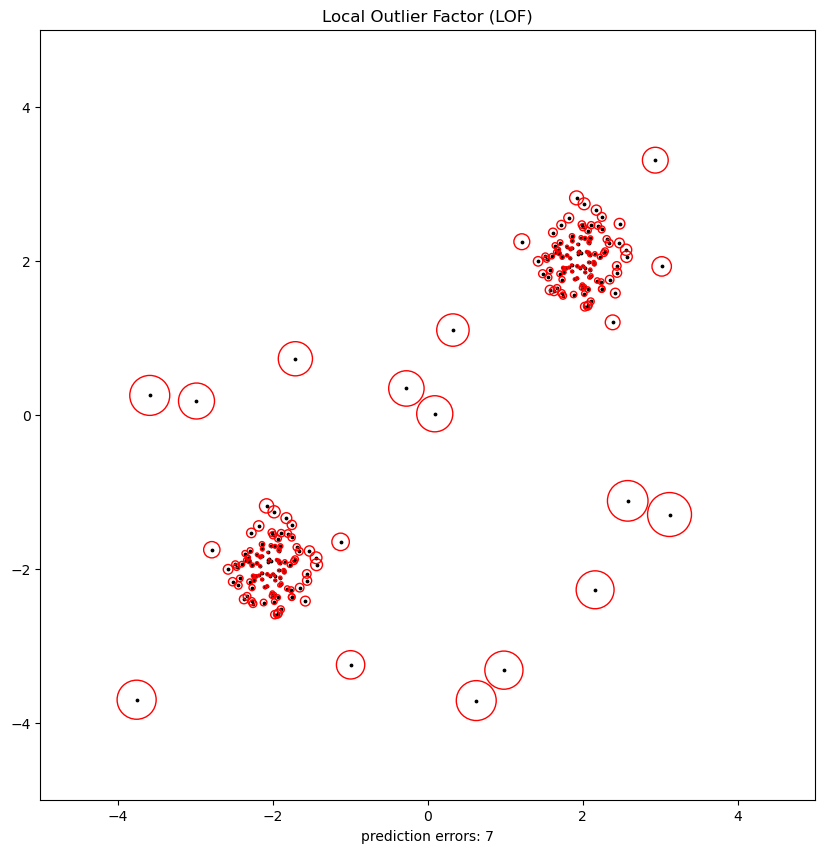

In [10]:
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerPathCollection

plt.scatter(X[:, 0], X[:, 1], color="k", s=3.0, label="Data points")
# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
scatter = plt.scatter(
    X[:, 0],
    X[:, 1],
    s=1000 * radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)
plt.axis("tight")
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.xlabel("prediction errors: %d" % (n_errors))
plt.title("Local Outlier Factor (LOF)")
plt.show()

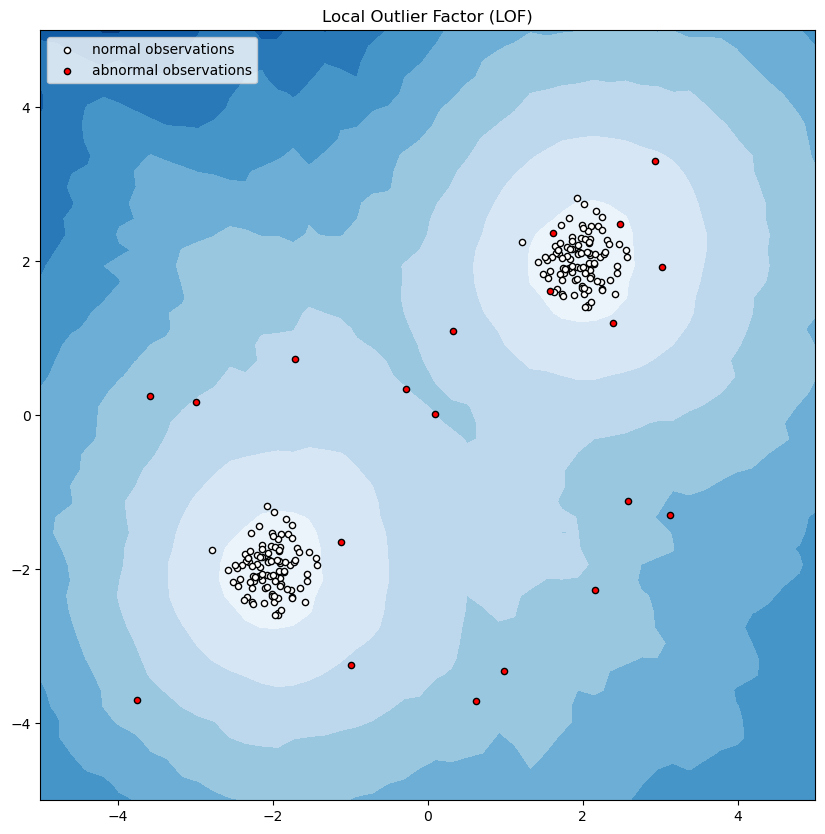

In [11]:
# plot the level sets of the decision function
xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)


plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

a = plt.scatter(X[:200, 0], X[:200, 1], c='white',
                edgecolor='k', s=20)
b = plt.scatter(X[200:, 0], X[200:, 1], c='red',
                edgecolor='k', s=20)
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a, b],
           ["normal observations",
            "abnormal observations"],
           loc="upper left")

plt.title("Local Outlier Factor (LOF)")

plt.show()

In [12]:
# fit the model
clf = IsolationForest(max_samples=100)
clf.fit(X)
y_pred_forest = clf.predict(X)

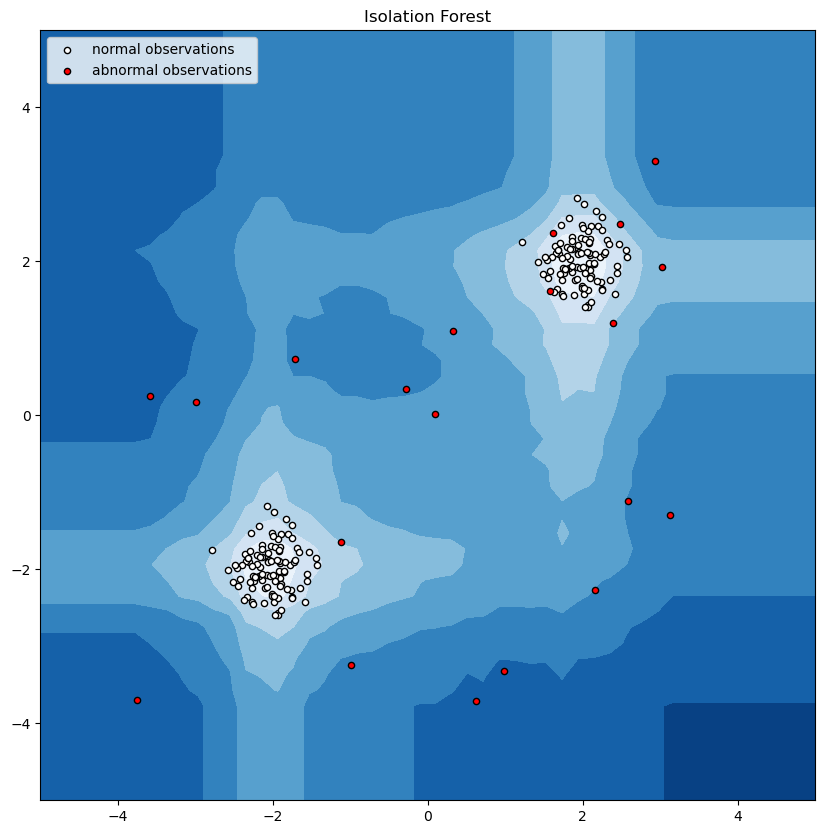

In [13]:
plt.title("Isolation Forest")

Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

a = plt.scatter(X[:200, 0], X[:200, 1], c='white',
                edgecolor='k', s=20)
b = plt.scatter(X[200:, 0], X[200:, 1], c='red',
                edgecolor='k', s=20)

plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a, b],
           ["normal observations",
            "abnormal observations"],
           loc="upper left")
plt.show()

Different methods, different results

## Direct exploration

The Boston housing dataset contains information about housing prices in Boston and various features that may affect those prices. Common features include:

- CRIM: Per capita crime rate by town.
- ZN: Proportion of residential land zoned for lots over 25,000 sq. ft.
- INDUS: Proportion of non-retail business acres per town.
- NOX: Nitric oxides concentration (parts per 10 million).
- RM: Average number of rooms per dwelling.
- AGE: Proportion of owner-occupied units built prior to 1940.
- DIS: Weighted distances to five Boston employment centers.
- RAD: Index of accessibility to radial highways.
- TAX: Full-value property tax rate per $10,000.
- PTRATIO: Pupil-teacher ratio by town.
- MEDV: Median value of owner-occupied homes in $1000s (the target variable).

Next Steps

Once you have the dataset loaded, you can proceed to perform outlier detection and removal. Here’s an outline of how you might do that:

- Exploratory Data Analysis (EDA):
Visualize the data using histograms, box plots, or scatter plots to identify potential outliers.

- Outlier Detection:
Use methods like Z-scores, Interquartile Range (IQR), Local Outlier Factor, or Isolation Forest to identify outliers in the dataset.

- Remove Outliers:
Filter the DataFrame to exclude detected outliers.

- Analysis After Outlier Removal:
Re-examine the dataset and perform any further analyses or model training.

In [14]:
from sklearn.datasets import fetch_openml
import pandas as pd

# Load Boston dataset from OpenML
boston = fetch_openml(name='boston', version=1, as_frame=True)
boston_df = boston.frame

y = boston.target

# Display the first few rows of the dataset
print(boston_df.head())


      CRIM    ZN  INDUS CHAS    NOX     RM   AGE     DIS RAD    TAX  PTRATIO  \
0  0.00632  18.0   2.31    0  0.538  6.575  65.2  4.0900   1  296.0     15.3   
1  0.02731   0.0   7.07    0  0.469  6.421  78.9  4.9671   2  242.0     17.8   
2  0.02729   0.0   7.07    0  0.469  7.185  61.1  4.9671   2  242.0     17.8   
3  0.03237   0.0   2.18    0  0.458  6.998  45.8  6.0622   3  222.0     18.7   
4  0.06905   0.0   2.18    0  0.458  7.147  54.2  6.0622   3  222.0     18.7   

        B  LSTAT  MEDV  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7  
3  394.63   2.94  33.4  
4  396.90   5.33  36.2  


In [16]:
print(boston['DESCR'])

**Author**:   
**Source**: Unknown - Date unknown  
**Please cite**:   

The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic
prices and the demand for clean air', J. Environ. Economics & Management,
vol.5, 81-102, 1978.   Used in Belsley, Kuh & Welsch, 'Regression diagnostics
...', Wiley, 1980.   N.B. Various transformations are used in the table on
pages 244-261 of the latter.
Variables in order:
CRIM     per capita crime rate by town
ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
INDUS    proportion of non-retail business acres per town
CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
NOX      nitric oxides concentration (parts per 10 million)
RM       average number of rooms per dwelling
AGE      proportion of owner-occupied units built prior to 1940
DIS      weighted distances to five Boston employment centres
RAD      index of accessibility to radial highways
TAX      full-value property-tax rate per $10

In [17]:
boston.feature_names

['CRIM',
 'ZN',
 'INDUS',
 'CHAS',
 'NOX',
 'RM',
 'AGE',
 'DIS',
 'RAD',
 'TAX',
 'PTRATIO',
 'B',
 'LSTAT']

In [18]:
'''
Load and return the boston house-prices dataset (regression).
Samples total 	506
Dimensionality 	13
Features 	real, positive
Targets 	real 5. - 50.
'''

#create the dataframe
boston_df = pd.DataFrame(boston.data)

boston_df.columns = boston.feature_names

boston_df.head()
boston_df.shape

(506, 13)

In [19]:
boston_df.to_csv("boston.csv", index=False)

In [20]:
boston.target

0      24.0
1      21.6
2      34.7
3      33.4
4      36.2
       ... 
501    22.4
502    20.6
503    23.9
504    22.0
505    11.9
Name: MEDV, Length: 506, dtype: float64

The `boston.target` attribute contains the target variable of the Boston housing dataset, which is the median value of owner-occupied homes in thousands of dollars (denoted as MEDV). Here's how to work with it, including displaying its contents and understanding its structure.

In [21]:
boston_df.describe()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.554695,6.284634,68.574901,3.795043,408.237154,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.115878,0.702617,28.148861,2.105710,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.385000,3.561000,2.900000,1.129600,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.449000,5.885500,45.025000,2.100175,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.538000,6.208500,77.500000,3.207450,330.000000,19.050000,391.440000,11.360000
75%,3.677083,12.500000,18.100000,0.624000,6.623500,94.075000,5.188425,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,0.871000,8.780000,100.000000,12.126500,711.000000,22.000000,396.900000,37.970000


In [22]:
%matplotlib inline
boston_df.boxplot(rot=90)

<Axes: >

<AxesSubplot:xlabel='DIS'>

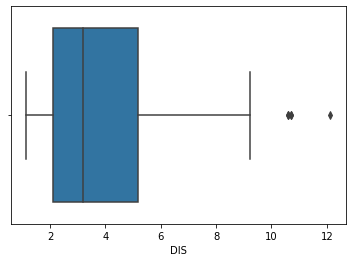

In [ ]:
%matplotlib inline
import seaborn as sns

sns.boxplot(x=boston_df['DIS'])


array([[<AxesSubplot:title={'center':'DIS'}>]], dtype=object)

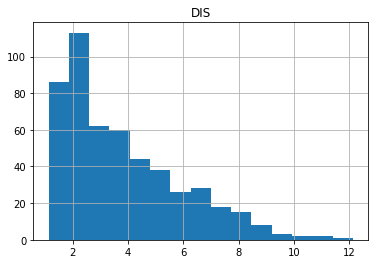

In [ ]:
boston_df.hist(column="DIS", bins='auto')

1. Set Random Seed:
- This line sets the random seed for NumPy's random number generator to ensure that the results are reproducible. This means that every time you run the code, you will get the same random numbers.
2. Generate Normally Distributed Data:
- This line creates a pandas DataFrame (`df`) with a single column named "Data".
- The `np.random.normal(size=200)` function generates 200 random samples from a standard normal distribution (mean = 0, standard deviation = 1).

array([[<AxesSubplot:title={'center':'Data'}>]], dtype=object)

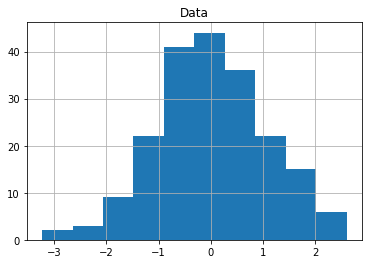

In [ ]:
# HERE WE CREATE A randomly generated dataset of normally distributed data 1-column.
import numpy as np
np.random.seed(123) #you can fix the random seed for reproducibility
df = pd.DataFrame({'Data':np.random.normal(size=200)})
df.hist(column="Data")

In [ ]:
df

,Data
0,-1.085631
1,0.997345
2,0.282978
3,-1.506295
4,-0.578600
...,...
195,-3.231055
196,-0.269293
197,-0.110851
198,-0.341262


<AxesSubplot:xlabel='Data'>

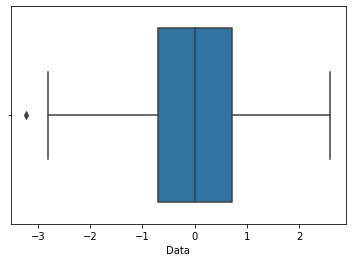

In [ ]:
sns.boxplot(x=df.Data)

In [ ]:
#since it is normal then I CAN REMOVE OUTLIERS Using Normal Distribution and S.D
mean = df.mean()
sd = df.std()

# keep only the ones that are within +x to -x standard deviations in the column DIS
x = 3
df = df[ np.abs(df - mean) <= 3 * sd ]

array([[<AxesSubplot:title={'center':'Data'}>]], dtype=object)

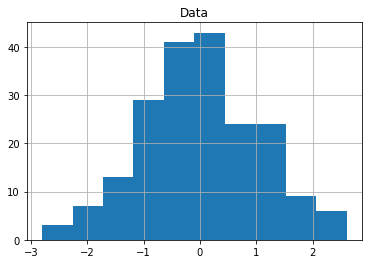

In [ ]:
df.hist(column="Data")

<AxesSubplot:xlabel='Data'>

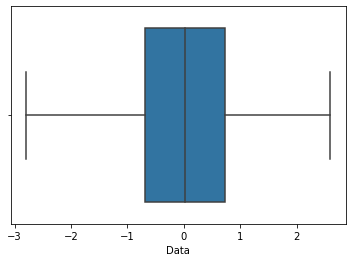

In [ ]:
sns.boxplot(x=df.Data)

<AxesSubplot:xlabel='CRIM'>

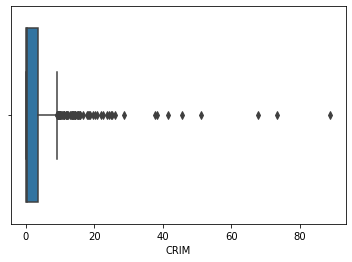

In [ ]:
## check your data first 
df2=pd.DataFrame(boston_df["CRIM"])
mean2 = df2.mean()
sd2 = df2.std()

df2.describe()
sns.boxplot(x=boston_df.CRIM)

#df2.shape

array([[<AxesSubplot:title={'center':'CRIM'}>]], dtype=object)

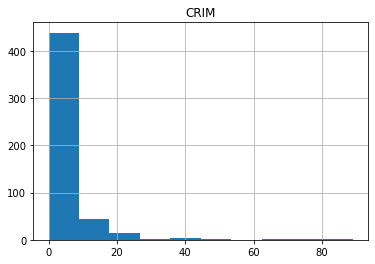

In [ ]:
df2.hist()


<AxesSubplot:>

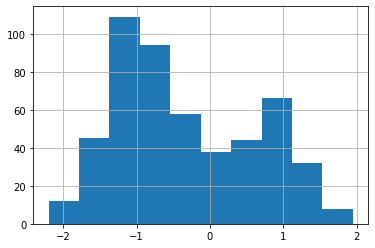

In [ ]:
#df2.hist()
import numpy as np
np.log10(boston_df["CRIM"]).hist()


This line calculates the base-10 logarithm of the "CRIM" values using np.log10().
The logarithmic transformation is useful for several reasons:

    - Reducing Skewness: Crime rate data is often positively skewed (many towns with low crime rates and few with very high rates). Taking the logarithm helps to normalize the distribution.
    - Highlighting Relative Differences: Log transformation can help highlight relative differences in lower values, making it easier to see patterns in data that spans several orders of magnitude.

After the transformation, the .hist() method creates a histogram of the transformed data.
Expected Output

    - Histogram of Log-Transformed Data:
        - The histogram will display the distribution of the log-transformed crime rates. You should expect:
            - A distribution that appears more normal than the original "CRIM" distribution, potentially reducing the effect of outliers.
            - The x-axis representing the log-transformed crime rates and the y-axis indicating the frequency of those transformed values.

<AxesSubplot:xlabel='CRIM'>

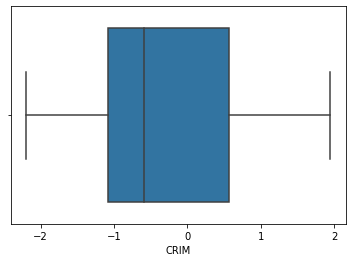

In [ ]:
import numpy as np

import seaborn as sns

sns.boxplot(x=np.log10(boston_df["CRIM"]))

<AxesSubplot:xlabel='CRIM', ylabel='MEDV'>

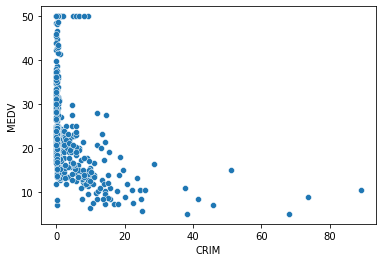

In [ ]:
sns.scatterplot(x=boston_df['CRIM'], y=y)